# 巡回セールスマン問題

巡回セールスマン問題とは、セールスマンが各都市を一度ずつ訪問し、出発点に戻る際の移動距離を最小化する問題です。本チュートリアルでは、日本の首都圏を舞台に巡回セールスマン問題をどのように解くかを説明します。

## 定式化

以下では、$n$ 都市の巡回セールスマン問題を考えることとします。また、巡回セールスマン問題はいくつかの線形定式化が知られていますが、本チュートリアルでは次のような2次定式化を採用するものとします。

### 決定変数

決定変数 $x_{i, t}$ を次のように定義するものとします。

$$
x_{i,t} = \begin{cases}
1~\text{the salesman visits $t$-th city $i$,}\\
0~\text{otherwise}\\
\end{cases}
$$

$$
i, t \in \{0, ..., n-1\}
$$

すなわち、$x_{i, t}$ はセールスマンが $t$ 番目に都市 $i$ を訪れた場合に1になり、そうでない時に0になるバイナリ変数です。

### 制約

次に以下の2つの制約を考えます。

1. 都市 $i$ に訪れるのは1度だけ

$$
\sum_t x_{i, t} = 1, ~\forall i
$$

2. $t$ 番目に訪れる都市は1つだけ

$$
\sum_i x_{i, t} = 1, ~\forall t 
$$

この2つの制約条件は $x_{i, t}$ がセールスマンの都市を巡る順序を表現する上で必要なものになっています。なぜなら、セールスマンは同時に複数の都市を訪問することはできませんし、同じ都市に何度も行く必要はないからです。

以下の図は、この2つの制約条件を満たしながら $x_{i, t}$ に値を割り当てたものになっています。このようなイメージで定式化を捉えると以降の説明が理解しやすくなるでしょう。

![](./assets/tsp_variable.png)

### 目的関数

最後に目的関数を考えましょう。巡回セールスマン問題はセールスマンの移動距離を最小化する問題なので、次のように定式化することができます。

$$
\sum_{i,j,t} d_{i, j}x_{i, t}x_{j, (t+1)\mod n}
$$

ここで $d_{i, j}$ は都市 $i$ と都市 $j$ の距離です。 $x_{i, t}x_{i, t+1}$ は $t$ 番目に都市 $i$ を訪れ、 $t+1$ 番目に都市 $j$ を訪れた時に値が1になり、そうでない時には値が0になります。上記の式で $x_{j, (t+1)\mod n}$ に $\mod n$ が含まれているのは、$n$ 番目に訪れた都市 $j$ から最初の都市に戻る移動を表現するためです。

### $n$都市の巡回セールスマン問題

これで定式化に必要なものが揃いました。$n$ 都市の巡回セールスマン問題は以下のように数理モデルで表すことができます。

$$
\begin{aligned}
\min_x \sum_{i, j} &d_{i,j} \sum_t x_{i,t} x_{j, (t+1) \mod n}\\
\mathrm{s.t.}~&\sum_i x_{i, t} = 1,~\forall t\\
&\sum_t x_{i, t} = 1, ~\forall i\\
&x_{i, t} \in \{0, 1\}
\end{aligned}
$$

## JijModelingによる定式化

JijModelingを使って上述の数理モデルを実装してみましょう。まずは、数理モデルに現れる変数およびパラメーターを定義します。

In [1]:
import jijmodeling as jm

d = jm.Placeholder('d', ndim=2)
N = d.len_at(0, latex="N")
i = jm.Element('i', belong_to=(0, N))
j = jm.Element('j', belong_to=(0, N))
t = jm.Element('t', belong_to=(0, N))
x = jm.BinaryVar('x', shape=(N, N))

ここで `d` は 都市 $i$ と都市 $j$ の距離 $d_{i, j}$ を要素に持つ2次元リストで、 `N` は都市数です。また、後の数理モデルの構築のために添字 `i`, `j`, `t`を定義しており、 `i`, `j` は都市 $i$ や $j$ を、 `t` は何番目に都市を訪れるかを意味します。そして、$x_{i, t}$ に相当するバイナリ変数として `x` を定義しています。

次に、目的関数を設定しましょう。

In [2]:
problem = jm.Problem("TSP")
problem += jm.sum([i, j], d[i, j] * jm.sum(t, x[i, t]*x[j, (t+1) % N]))

そして、2つの制約条件を定義しましょう。

In [3]:
problem += jm.Constraint("one-city", x[:, t].sum() == 1, forall=t)
problem += jm.Constraint("one-time", x[i, :].sum() == 1, forall=i)

ここでは `"one-city"` と名付けられている `jm.Constraint` オブジェクトにより、都市 $i$ に訪れるのは1度だけを意味する制約を定義しています。
そして`"one-time"` と名付けられている `jm.Constraint` オブジェクトによって、$t$ 番目に訪れる都市は1つだけを意味する制約条件を設定しています。

これで数理モデルの実装は完了です。正しく数理モデルが実装されているかをLaTeX表示を通して確認してみましょう。

In [4]:
problem

## インスタンスデータの準備

次はパラメーターに入力するインスタンスデータを準備します。
ここでは `geopy` を用いて日本の首都圏（関東平野）の都県を回る問題を考えてみましょう。

In [6]:
from geopy.geocoders import Nominatim
import numpy as np

geolocator = Nominatim(user_agent='python')

# set the name list of traveling points
points = ['茨城県', '栃木県', '群馬県', '埼玉県', '千葉県', '東京都', '神奈川県']

# get the latitude and longitude
latlng_list = []
for point in points:
    location = geolocator.geocode(point)
    if location is not None:
        latlng_list.append([ location.latitude, location.longitude ])
# make distance matrix
num_points = len(points)
inst_d = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(num_points):
        a = np.array(latlng_list[i])
        b = np.array(latlng_list[j])
        inst_d[i][j] = np.linalg.norm(a-b)
# normalize distance matrix
inst_d = (inst_d-inst_d.min()) / (inst_d.max()-inst_d.min())

geo_data = {'points': points, 'latlng_list': latlng_list}
instance_data = {'d': inst_d}

## 巡回セールスマン問題を解く

`jijsolver`を用いて、巡回セールスマン問題を解きましょう。

In [7]:
import jijsolver

interpreter = jm.Interpreter(instance_data)
instance = interpreter.eval_problem(problem)
solution = jijsolver.solve(instance, time_limit_sec=1.0)

## 解の可視化

得られた解を用いて、セールスマンが都市を訪問する順序を可視化してみましょう。

[[0, 0], [1, 1], [2, 2], [3, 3], [4, 6], [5, 5], [6, 4]]


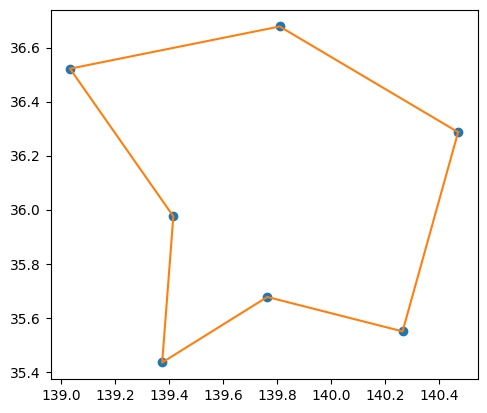

['茨城県' '栃木県' '群馬県' '埼玉県' '神奈川県' '東京都' '千葉県' '茨城県']


In [11]:
import matplotlib.pyplot as plt

df = solution.decision_variables
x_indices = df[df["value"] == 1.0]["subscripts"]
tour = [index for index, _ in sorted(x_indices, key=lambda x: x[1])]
tour.append(tour[0])

position = np.array(geo_data['latlng_list']).T[[1, 0]]

plt.axes().set_aspect('equal')
plt.plot(*position, "o")
plt.plot(position[0][tour], position[1][tour], "-")
plt.show()

print(np.array(geo_data['points'])[tour])